In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0
Receiving objects: 100% (193/193), 2.59 MiB | 15.49 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-6tz46_t0
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-6tz46_t0
  Resolved https://github.com/albumentations-team/albumentations to commit 812951874a170040dd5650fa35bc6025bf3c96f7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 50.3 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumen

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# CONFIGS

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
#0: Cucomber
#1: Eggplant
#2: Mushrooms

data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
train_df, valid_df = train_test_split(data, test_size=0.2, random_state=42)

# Augmentations

In [7]:
train_augs = A.Compose([
        A.Rotate(),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

valid_augs = A.Compose([
        A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

In [8]:
train_set = utils.ImageDataset(train_df, augs = train_augs, data_dir=DATA_DIR)
valid_set = utils.ImageDataset(valid_df, augs = valid_augs, data_dir=DATA_DIR)


Text(0.5, 1.0, 'cucumber')

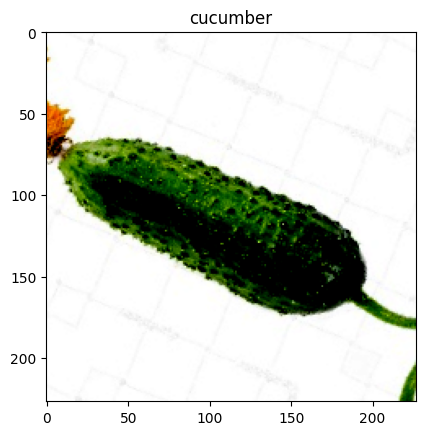

In [9]:
image, label = train_set[50] #C,W,H

class_list = ["cucumber", "eggplant", "mushroom"]

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])

In [10]:
print(f"len of train_set = {len(train_set)}")
print(f"len of valid_set = {len(valid_set)}")

len of train_set = 148
len of valid_set = 38


In [11]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size = BATCH_SIZE, shuffle=True)

In [12]:
print(f"No. batches of train_loader = {len(train_loader)}")
print(f"No. batches of valid_loader = {len(valid_loader)}")

No. batches of train_loader = 10
No. batches of valid_loader = 3


In [13]:
for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

torch.Size([16, 3, 227, 227])
torch.Size([16])


# Model

In [34]:
class ImageModel(nn.Module):
  def __init__(self):
    super(ImageModel, self).__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4, 4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4, 4), stride=2),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(4, 4), stride=2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=1),
        nn.ReLU()
    )

    self.maxpool = nn.MaxPool2d(kernel_size=(4, 4), stride=2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048, 3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images) #Activation_maps

    h = x.register_hook(self.activations_hook)

    x = self.maxpool(x)
    x = self.classifier(x)

    return x

  def get_activation_gradients(self): #a1, a2, a3, ...
    return self.gradient

  def get_activation(self, x): #A1, A2, A3, ...
    return self.feature_extractor(x)

In [35]:
model = ImageModel()
model.to(DEVICE)
model

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# TRAIN

In [41]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()

    logits = model(images)

    loss = criterion(logits, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(dataloader)


In [42]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)

    loss = criterion(logits, labels)

    total_loss += loss.item()

  return total_loss/len(dataloader)


In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [44]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer, criterion)
  valid_loss = eval_fn(valid_loader, model, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pth")
    best_valid_loss = valid_loss
    print("Model in saved!")

  print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")


100%|██████████| 3/3 [00:00<00:00, 30.29it/s]


Model in saved!
Epoch: 0, train_loss: 0.5498371869325638, valid_loss: 0.23947648704051971


100%|██████████| 3/3 [00:00<00:00, 34.28it/s]


Epoch: 1, train_loss: 0.2775030009448528, valid_loss: 0.30778175095717114


100%|██████████| 3/3 [00:00<00:00, 33.81it/s]


Epoch: 2, train_loss: 0.27728204540908336, valid_loss: 0.5626425947993994


100%|██████████| 3/3 [00:00<00:00, 37.11it/s]


Model in saved!
Epoch: 3, train_loss: 0.6002411156892776, valid_loss: 0.20421010007460913


100%|██████████| 3/3 [00:00<00:00, 38.17it/s]


Epoch: 4, train_loss: 0.2655692543834448, valid_loss: 0.23176639278729758


100%|██████████| 3/3 [00:00<00:00, 39.00it/s]


Epoch: 5, train_loss: 0.16104939822107553, valid_loss: 0.27180594702561695


100%|██████████| 3/3 [00:00<00:00, 26.19it/s]


Model in saved!
Epoch: 6, train_loss: 0.11184416702017189, valid_loss: 0.08013869139055411


100%|██████████| 3/3 [00:00<00:00, 26.53it/s]


Epoch: 7, train_loss: 0.12072792372200639, valid_loss: 0.3494764007627964


100%|██████████| 3/3 [00:00<00:00, 32.85it/s]


Epoch: 8, train_loss: 0.10574843231588602, valid_loss: 0.13152296592791876


100%|██████████| 3/3 [00:00<00:00, 36.70it/s]


Epoch: 9, train_loss: 0.20336463257553988, valid_loss: 0.37448418140411377


100%|██████████| 3/3 [00:00<00:00, 39.67it/s]


Epoch: 10, train_loss: 0.12287794966250658, valid_loss: 0.12194500615199406


100%|██████████| 3/3 [00:00<00:00, 38.25it/s]


Epoch: 11, train_loss: 0.11510022879228927, valid_loss: 0.16219022198735425


100%|██████████| 3/3 [00:00<00:00, 38.42it/s]


Model in saved!
Epoch: 12, train_loss: 0.05952602806501091, valid_loss: 0.07307612275083859


100%|██████████| 3/3 [00:00<00:00, 37.98it/s]


Model in saved!
Epoch: 13, train_loss: 0.06736941542476416, valid_loss: 0.030812604663272698


100%|██████████| 3/3 [00:00<00:00, 37.89it/s]


Epoch: 14, train_loss: 0.021435935865156353, valid_loss: 0.05037540263341119


100%|██████████| 3/3 [00:00<00:00, 40.07it/s]


Epoch: 15, train_loss: 0.02864450743654743, valid_loss: 0.13139972432206073


100%|██████████| 3/3 [00:00<00:00, 36.24it/s]


Epoch: 16, train_loss: 0.020051260315813123, valid_loss: 0.18099711893288864


100%|██████████| 3/3 [00:00<00:00, 40.50it/s]


Epoch: 17, train_loss: 0.06488114526582649, valid_loss: 0.2885651540321608


100%|██████████| 3/3 [00:00<00:00, 40.51it/s]


Epoch: 18, train_loss: 0.06522686862736009, valid_loss: 0.6362881201008955


100%|██████████| 3/3 [00:00<00:00, 37.91it/s]

Epoch: 19, train_loss: 0.08066083642287367, valid_loss: 0.5425162251728276


# GET GradCAM

In [46]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) #a1, a2, .., ak
  activations = model.get_activation(image).detach() #A1, A2, ..., Ak

  for i in range(activations.shape[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim=1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size, size))

  return heatmap

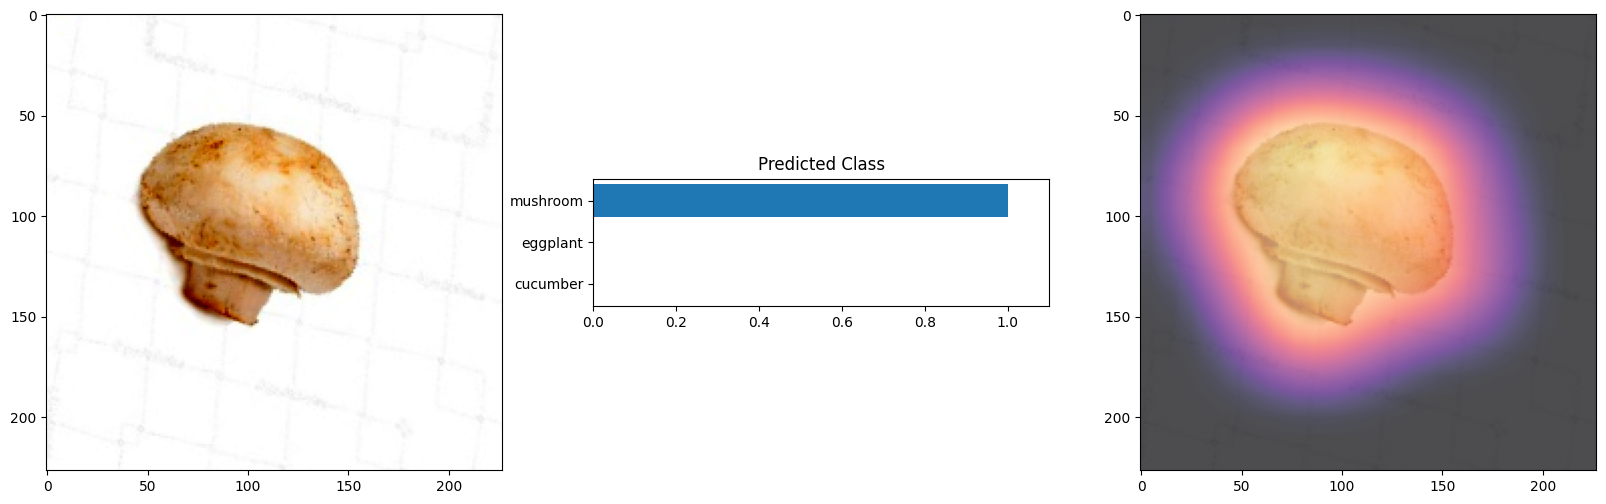

In [89]:
image, label = train_set[95]

denorm_image = image.permute(1,2,0)

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)

heatmap = get_gradcam(model, image, pred[0][2], size = image.shape[3])
utils.plot_heatmap(denorm_image, pred, heatmap)